# **CRM Analytics - Data Analysis**

**Importing libraries**

In [28]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utils libraries
import pylab as pl
from datetime import datetime
from dateutil import relativedelta

# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

**Importing cleaned datasets into Jupyter Notebook**

In [29]:
# Uploading cleaned datasets
cases = pd.read_csv('data/cases_cleaned.csv', parse_dates = ['date_ref'])
creds = pd.read_csv('data/creds_cleaned.csv', parse_dates = ['cred_date'])

In [30]:
# Recoverig waiting_timedelta data to timedelta objetct
cases['waiting_timedelta'] = pd.to_timedelta(cases['waiting_timedelta'])

## Effect of new functionality on CR calls

In [31]:
# Creating reference value for future information grouping
cases['calls'] = 1
# cases.head(3)

In [32]:
# Checking upper and lower bonderies dates in the dataset
print('Dataset date break              : ', cases['date_ref'].max())
print('New feature implementation date : ', pd.to_datetime('2020-08-01'))

Dataset date break              :  2020-10-29 00:00:00
New feature implementation date :  2020-08-01 00:00:00


In [33]:
cases_agg = cases.groupby('date_ref')[['account_id']].count()
cases_agg.rename(columns = {'account_id': 'n_cases'}, inplace = True)
cases_agg.head()

,n_cases
date_ref,
2020-02-23,1
2020-02-25,1
2020-02-26,22
2020-02-27,31
2020-02-28,27


**Separating dataset before and after the implementation of the new feature**

After creating a dataset with aggregated data for the required analysis, and based on the data available, to determine if the feature implemented in early August helped to _decrease_ the number of calls to the Customer Relation (CR) center, it is necessary to separate the aggregate dataset in two: one before the feature implementation date, August 1, 2020, and another after that date. Thus, it is possible to make a comparison between the averages as well as other statistical analysis.

Before, however, we check the amount of data that will be in each of these datasets after splitting:

In [34]:
# Saving the implementation date of the new feature in a new variable: 'shift_date'
shift_date = pd.to_datetime('2020-08-01')

In [35]:
# Checking dataset shapes
cases_agg[cases_agg.index < shift_date].shape, cases_agg[cases_agg.index >= shift_date].shape

((155, 1), (90, 1))

As suspected, the data is **unbalanced**. We will check some statistics of the data in each of them and see how this imbalance could affect our analysis.

In [36]:
# Checking average number of calls before and after implementation of new feature
mean_n_cases_before = cases_agg[cases_agg.index < shift_date]['n_cases'].mean()
print('Average # of calls before shift_date: ', 
      round(mean_n_cases_before, 2))

mean_n_cases_after = cases_agg[cases_agg.index >= shift_date]['n_cases'].mean()
print('Average # of calls after shift_date : ', 
      round(mean_n_cases_after, 2))

Average # of calls before shift_date:  196.21
Average # of calls after shift_date :  523.08


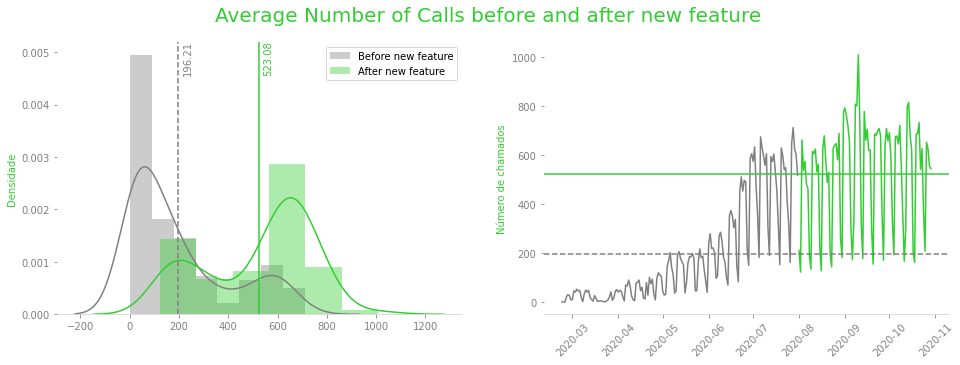

In [37]:
# Plotting a histogram to visualize the difference
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
fig.suptitle('Average Number of Calls before and after new feature', fontsize = 20, color = 'limegreen')

sns.distplot(cases_agg[cases_agg.index < shift_date], color = 'gray', label = 'Before new feature', ax = ax[0]) 
sns.distplot(cases_agg[cases_agg.index >= shift_date], color = 'limegreen', label = 'After new feature', ax = ax[0])
ax[0].axvline(mean_n_cases_before, color = 'gray', linestyle = '--')
ax[0].axvline(mean_n_cases_after, color = 'limegreen', linestyle = '-')
ax[0].set(ylabel = "Densidade")
ax[0].text(x = mean_n_cases_before + 20, y = 0.0046, s = round(mean_n_cases_before, 2), rotation = 90, color = 'gray')
ax[0].text(x = mean_n_cases_after + 20, y = 0.0046, s = round(mean_n_cases_after, 2), rotation = 90, color = 'limegreen')
ax[0].legend()

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray')
ax[0].yaxis.label.set_color('limegreen')

plt.plot(cases_agg[cases_agg.index < shift_date]['n_cases'], color = 'gray', label = 'Before new feature')
plt.plot(cases_agg[cases_agg.index >= shift_date]['n_cases'], color = 'limegreen', label = 'After new feature')
plt.ylabel('Número de chamados')
ax[1].axhline(mean_n_cases_before, color = 'gray', linestyle = '--')
ax[1].axhline(mean_n_cases_after, color = 'limegreen', linestyle = '-')

ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
ax[1].yaxis.label.set_color("limegreen")

plt.xticks(rotation = 45)
# ax[1].legend()

sns.despine(top = True, left = True)
plt.show()

The graph with the unbalanced data includes a business moment when the number of calls to the Customer Relationship center was small. This makes the averages for the two periods very different, not ideal for this analysis.

We will balance the dataset including the same number of days before and after the implementation of the new feature.


In [38]:
# Setting a date for balancing the data
first_date = shift_date - np.timedelta64(90, 'D') # 90 days, including shift_date
first_date # 2020-05-03

Timestamp('2020-05-03 00:00:00')

In [39]:
# Balancing the data from the two datasets by selecting the same number of entries (days) for both
cases_before = cases_agg[(cases_agg.index >= first_date) & (cases_agg.index < shift_date)]
cases_after = cases_agg[cases_agg.index >= shift_date]

# Checking datasets shape after balancing
cases_before.shape, cases_after.shape

((90, 1), (90, 1))

The two datasets now have the same number of days, which makes our analysis feasible.
However, the period before the implementation of the new feature still includes a period when the business was growing. Which again makes the analysis unfair.

To **normalize** the data, one strategy is to analyze the scenario: who are the people who make the calls to the CR center? Customers registered in the database. Even though most calls are made by new customers, as we will investigate later, everyone can make calls to the CR.

One way to normalize this data would therefore be to divide the number of calls by the total number of customers registered in the database on a certain date and then the comparison of averages would be fairer.

**Normalizing the data: daily calls by total size of customer base**

To perform this calculation, we first need to calculate the cumulative sum of tickets:

In [40]:
# cases_agg_full = cases.groupby('date_ref').agg({'account_id': ['count'], 
#                                            'pesq_satisfacao': 'count',
#                                            'waiting_time': 'mean'})

In [41]:
# # Creating table with number of cases (calls) aggregated by registration date
# cases_agg = cases.groupby('date_ref')[['account_id']].count()

# # Renaming aggregate column for easy understanding
# cases_agg = cases_agg.rename(columns = {'account_id': 'n_cases'})

# Creating a column for accumulated sum of calls (dataset size)
cases_agg['cases_cumsum'] = cases_agg['n_cases'].cumsum()
cases_agg

,n_cases,cases_cumsum
date_ref,,
2020-02-23,1,1
2020-02-25,1,2
2020-02-26,22,24
2020-02-27,31,55
2020-02-28,27,82
...,...,...
2020-10-25,208,75110
2020-10-26,652,75762
2020-10-27,627,76389


The table of aggregated cases, as we saw earlier, contains unbalanced data (more days before the implementation of the feature, less days after). We must again discard the data given prior to 90 days before the implementation of the feature (according to information previously calculated and stored in the variable `first_date`).

In [42]:
# Selecting cutoff period for analysis of statistical relevance in the Cases table
cases_tomerge = cases_agg[cases_agg.index >= first_date]
cases_tomerge

,n_cases,cases_cumsum
date_ref,,
2020-05-03,32,2634
2020-05-04,147,2781
2020-05-05,169,2950
2020-05-06,202,3152
2020-05-07,141,3293
...,...,...
2020-10-25,208,75110
2020-10-26,652,75762
2020-10-27,627,76389


The normalization of data requires that we seek information about the number of registered customers on the `creds` dataset. It will be necessary to create a JOIN of these two tables, having the date as _index_. For this reason, the dataset created thus takes the suffix `_tomerge`.

Now, we have created an aggregate dataset with information from the registration (`creds`) table, including the number of daily registrations and the cumulative sum of registered customers:

In [43]:
# Creating table with number of cases (calls) data aggregated by registration date
creds_agg = creds.groupby('cred_date').count()[['account_id']]

# Renaming column for readability
creds_agg = creds_agg.rename(columns = {'account_id': 'n_creds'})

# Creating column for cumulative sum of calls
creds_agg['cumsum_creds'] = creds_agg['n_creds'].cumsum()

creds_agg

,n_creds,cumsum_creds
cred_date,,
2019-07-24,12,12
2019-07-25,15,27
2019-07-26,23,50
2019-07-27,9,59
2019-07-28,4,63
...,...,...
2020-10-26,11,31235
2020-10-27,85,31320
2020-10-28,53,31373


Again, also for this dataset we select only the data of our interest, discarding values older than 90 days:

In [44]:
# Selecting cutoff period for analysis of statistical relevance in the Creds table
creds_tomerge = creds_agg[creds_agg.index >= first_date]
creds_tomerge.head()

,n_creds,cumsum_creds
cred_date,,
2020-05-03,21,3994
2020-05-04,68,4062
2020-05-05,161,4223
2020-05-06,131,4354
2020-05-07,123,4477


**JOINing both tables**

In [45]:
cred_cases = creds_tomerge.merge(cases_tomerge, how = 'inner', left_index = True, right_index = True)
cred_cases.head()
cred_cases.shape

(180, 4)

**Calculating the number of calls by the total number of customers registered on the daily basis, `calls_per_total_creds`**

In [46]:
cred_cases['calls_per_new_creds'] = round((cred_cases['n_cases'] / cred_cases['n_creds']), 2)
cred_cases['calls_per_total_creds'] = round((cred_cases['n_cases'] / cred_cases['cumsum_creds']), 5)
cred_cases.head()

,n_creds,cumsum_creds,n_cases,cases_cumsum,calls_per_new_creds,calls_per_total_creds
2020-05-03,21,3994,32,2634,1.52,0.00801
2020-05-04,68,4062,147,2781,2.16,0.03619
2020-05-05,161,4223,169,2950,1.05,0.04002
2020-05-06,131,4354,202,3152,1.54,0.04639
2020-05-07,123,4477,141,3293,1.15,0.03149


In [47]:
# Separating aggregated table into two: before and after the implementation of the new feature
cred_cases_before = cred_cases[cred_cases.index < shift_date]
cred_cases_after = cred_cases[cred_cases.index >= shift_date]

cred_cases_before.shape, cred_cases_after.shape

((90, 6), (90, 6))

In [48]:
# Checking correctess of cutoff date
cred_cases_after.head(1) # First date is 2020-08-01, so far, so good!

,n_creds,cumsum_creds,n_cases,cases_cumsum,calls_per_new_creds,calls_per_total_creds
2020-08-01,128,17482,211,30623,1.65,0.01207


In [49]:
# Checking average calls in the periods before and after the new feature
mean_cases_per_total_creds_before = cred_cases_before['calls_per_total_creds'].mean()
print('Average # of calls by database size before shift_date: ', 
      round(mean_cases_per_total_creds_before, 5))

mean_cases_per_total_creds_after = cred_cases_after['calls_per_total_creds'].mean()
print('Average # of calls by database size after shift_date : ', 
      round(mean_cases_per_total_creds_after, 5))

Average # of calls by database size before shift_date:  0.02959
Average # of calls by database size after shift_date :  0.02119


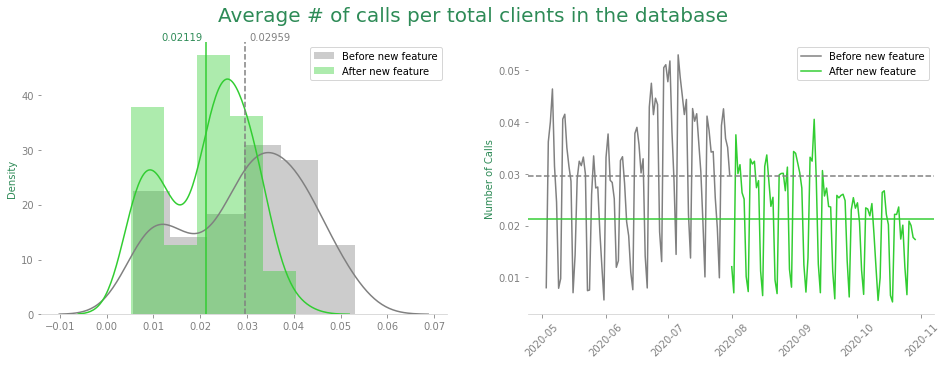

In [50]:
# Plotting histogram to visulize differnce
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

plt.gcf()
fig.suptitle('Average # of calls per total clients in the database', fontsize = 20, color = 'seagreen')

sns.distplot(cred_cases_before['calls_per_total_creds'], color = 'gray', label = 'Before new feature', ax = ax[0]) 
sns.distplot(cred_cases_after['calls_per_total_creds'], color = 'limegreen', label = 'After new feature', ax = ax[0])
ax[0].axvline(mean_cases_per_total_creds_before, color = 'gray', linestyle = '--')
ax[0].axvline(mean_cases_per_total_creds_after, color = 'limegreen', linestyle = '-')
ax[0].set(ylabel = "Density", xlabel = '')
ax[0].text(x = mean_cases_per_total_creds_before + 0.001, y = 50, s = round(mean_cases_per_total_creds_before, 5), rotation = 0, color = 'gray')
ax[0].text(x = mean_cases_per_total_creds_after - .0095, y = 50, s = round(mean_cases_per_total_creds_after, 5), rotation = 0, color = 'seagreen')
ax[0].legend()

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray')
ax[0].yaxis.label.set_color("seagreen")

plt.plot(cred_cases_before['calls_per_total_creds'], color = 'gray', label = 'Before new feature')
plt.plot(cred_cases_after['calls_per_total_creds'], color = 'limegreen', label = 'After new feature')
plt.ylabel('Number of Calls')
ax[1].axhline(mean_cases_per_total_creds_before, color = 'gray', linestyle = '--')
ax[1].axhline(mean_cases_per_total_creds_after, color = 'limegreen', linestyle = '-')

ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
ax[1].yaxis.label.set_color("seagreen")

plt.xticks(rotation = 45)
ax[1].legend()

sns.despine(top = True, left = True)
plt.show()

**Checking standard deviation of both distributions**

In [51]:
std_cases_per_total_creds_before = cred_cases_before['calls_per_total_creds'].std(ddof = 0)
print('Standard deviation of calls by the size of the registered customers base before shift_date: ', 
      round(std_cases_per_total_creds_before, 4))

std_cases_per_total_creds_after = cred_cases_after['calls_per_total_creds'].std(ddof = 0)
print('Standard deviation of calls by the size of the registered customers base after shift_date : ', 
      round(std_cases_per_total_creds_after, 4))

Standard deviation of calls by the size of the registered customers base before shift_date:  0.0128
Standard deviation of calls by the size of the registered customers base after shift_date :  0.0092


We observed that, after the implementation of the new feature, there was a decrease in the average number of calls by the total number of customers registered in the database. However, the order of magnitude between the difference in _means_ can be measured in thousandths and its standard deviations show that with a small variation in the data, the means can be even less different.

To find out if this difference is statistically significant, it is necessary to conduct a hypothesis test.

### Hypothesis testing for non-parametric distributions

First of all, let's establish our test hypotheses and set an alpha value:
  
<br>
<b><center> <mark>H<sub>0</sub>: The number of calls has remained the same. </mark> </center>
<br>
<center> <mark>H<sub>a</sub>: The number of calls has decreased. </mark> </center> </b>

The **_alpha_** value in our test is the level of risk we accept when deciding that an effect exists, when in fact it does not exist. A standard value for hypothesis testing is alpha = 5%, however, as our sample is relatively small, we can assume a value of **10%**.

Then, we need to make some assumptions about our data.

1. Non-parametric distribution (does not follow the normal or Gaussian distribution);
2. The samples are dependent, since the individuals making the calls can be the same, and in addition, we've converted the number of calls into a call rate per database size.

The **Wilcoxon test** meets the requirements for these assumptions.

**Applying Wilcoxon test to data**

In [52]:
from scipy.stats import wilcoxon

statistic, p = wilcoxon(cred_cases_before['calls_per_total_creds'], # p is the p-value
               cred_cases_after['calls_per_total_creds'], alternative = 'less') # Alternative = 'less' tests 
                                                                                # for cases when we evaluate the
                                                                                # alternate hypothesis as smaller
                                                                                # having decreased
alpha = 0.1 #
if p > alpha:
    print('There is no difference between distributions (Fail to reject H0); p-value: ', p)
else:
    print('There is a difference between the distributions (Rejects H0); p-value: ', p)

There is no difference between distributions (Fail to reject H0); p-value:  0.9999956294765974


In [53]:
# BETTER EXPLAIN THE P-VALUE CONCEPT AND RESULT

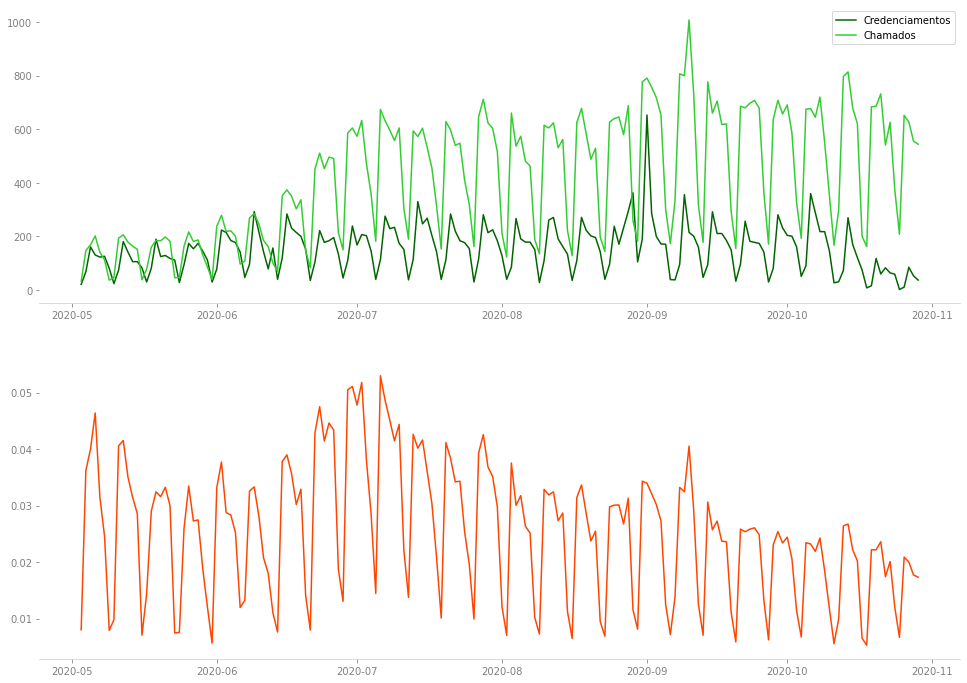

In [54]:
fig, ax = plt.subplots(2, 1, figsize = (16.5, 12))

ax[0].plot(cred_cases['n_creds'], label = 'Credenciamentos', color = 'darkgreen')
ax[0].plot(cred_cases['n_cases'], label = 'Chamados', color = 'limegreen')
ax[0].spines['bottom'].set_color('lightgray')
ax[0].legend(loc = 'best')

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray')
ax[0].yaxis.label.set_color("seagreen")

# plt.plot(cred_cases['n_cases'] - cred_cases['n_creds'])

ax[1].plot(cred_cases['calls_per_total_creds'], color = 'orangered')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
# ax[1].yaxis.label.set_color("seagreen")

sns.despine(top = True, left = True)
plt.show()

In [55]:
# TALVEZ UMA MODELO TIME SERIES PARA VERIFICAR A TENDENCIA DE CREDENCIAMENTOS, CHAMADOS E CHAMADOS/CREDENCIAMENTOS

___

In [56]:
# Juntando dados (selecionados acima) da tabela cred à tabela cases
mcases = cases.merge(creds, on = 'account_id', how = 'left', suffixes = ('_cases', '_creds'))
mcases.head(3)

,account_id,date_ref,waiting_time,missed,pesq_satisfacao,assunto,waiting_timedelta,year_cases,month_cases,day_cases,weekday_cases,weekday_str_cases,node_1,node_2,node_3,calls,cred_date,ship_city,ship_state,max_machine,year_creds,month_creds,day_creds,weekday_creds,weekday_str_creds
0,0011L00002ZbpnlQAB,2020-02-23,19,False,Enviado,"['Produto', 'mPOS', 'Dúvidas mpos']",0 days 00:00:19,2020,2,23,6,Dom,Produto,mPOS,Dúvidas mpos,1,2019-10-28,Atibaia,SP,T1,2019,10,28,0,Seg
1,0011L00002dbBg5QAE,2020-02-25,15,False,Enviado,"['Aplicativo', 'Problema', '']",0 days 00:00:15,2020,2,25,1,Ter,Aplicativo,Problema,NaN,1,2020-02-12,Alexânia,GO,T3,2020,2,12,2,Qua
2,0011L00002WdgbcQAB,2020-02-26,15,False,Enviado,"['Aplicativo', 'Dúvidas funcionalidades App', ...",0 days 00:00:15,2020,2,26,2,Qua,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,1,2019-07-28,Indaiatuba,SP,NONE,2019,7,28,6,Dom


In [57]:
mcases['interval_cred_call'] = (mcases['date_ref'] - mcases['cred_date']).dt.days
mcases.head(3)

,account_id,date_ref,waiting_time,missed,pesq_satisfacao,assunto,waiting_timedelta,year_cases,month_cases,day_cases,weekday_cases,weekday_str_cases,node_1,node_2,node_3,calls,cred_date,ship_city,ship_state,max_machine,year_creds,month_creds,day_creds,weekday_creds,weekday_str_creds,interval_cred_call
0,0011L00002ZbpnlQAB,2020-02-23,19,False,Enviado,"['Produto', 'mPOS', 'Dúvidas mpos']",0 days 00:00:19,2020,2,23,6,Dom,Produto,mPOS,Dúvidas mpos,1,2019-10-28,Atibaia,SP,T1,2019,10,28,0,Seg,118
1,0011L00002dbBg5QAE,2020-02-25,15,False,Enviado,"['Aplicativo', 'Problema', '']",0 days 00:00:15,2020,2,25,1,Ter,Aplicativo,Problema,NaN,1,2020-02-12,Alexânia,GO,T3,2020,2,12,2,Qua,13
2,0011L00002WdgbcQAB,2020-02-26,15,False,Enviado,"['Aplicativo', 'Dúvidas funcionalidades App', ...",0 days 00:00:15,2020,2,26,2,Qua,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,1,2019-07-28,Indaiatuba,SP,NONE,2019,7,28,6,Dom,213


In [66]:
def n_call_timewindow(df, n_days = 100, plot = False):
    '''
    This function calculates the number of calls (cases) after n_days // 7 entrance in the cred database and returns a pd.DataFrame with columns being the weeks ahead of entrance.
    
    Parameters:
    
    ** n_days (default, 100):
    Number of days to be included in the analysis. Please observe that the output will be in weeks, therefore the number of days will be divided by 7, and remainders will be discarded.
    
    ** plot (default, False):
    If set to True, will plot a horizontal bar chat instead of showing a pd.DataFrame.\n
    ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    '''
    df = df.copy()
    
    week = n_days // 7
    for i in range(0, week + 1):
        if i == 0:
            df[f'Semana #{i + 1}'] = (df['interval_cred_call'] <= (i + 7)).astype(int)
#             print(f'interval_{i + 7}\nn_calls: ', df[f'interval_{i + 7}'].value_counts()[1], '\n================')
        else:
            df[f'Semana #{i + 1}'] = ((df['interval_cred_call'] > (i * 7)) & 
                                             (df['interval_cred_call'] <= ((i + 1) * 7))).astype(int)
#             print(f'interval_{(i + 1) + 7}\nn_calls: ', df[f'interval_{((i + 1) * 7)}'].value_counts()[1], '\n================')
    
    df = df.iloc[:, -(week + 1):-1] # INCLUIR COLUNA 'account_id'
    
    if plot:
        fig, ax = plt.subplots(1, figsize = (15, 5))
        fig.suptitle('Total de chamados realizados após Credenciamento\n(por semana, a partir da entrada na base)',
                     fontsize = 20, color = 'darkgreen')
        fig.tight_layout()
        df.sum().plot(kind = 'barh', alpha = .8, width = .8, color = 'limegreen', zorder = 2).invert_yaxis()
        ax.grid(b = True, axis = 'x', alpha = .2, zorder = 1)
        ax.tick_params(axis='both', colors='gray', labelsize = 14, labelcolor = 'dimgray')
        ax.spines['left'].set_color('lightgray')
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        return f'{fig}'

    return df

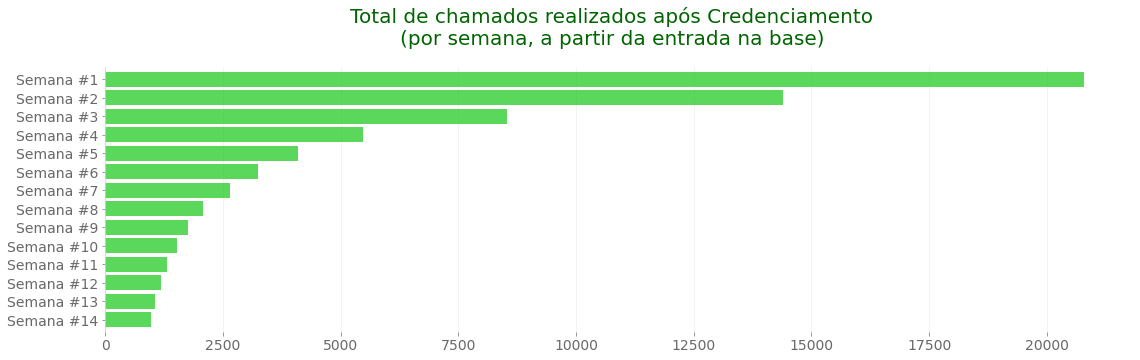

In [67]:
n_call_timewindow(mcases, n_days = 100, plot = True);

In [308]:
# Substituindo valores 'NONE' em max_machine por np.nan

# Criando função que irá substituir os valores NONE
def to_nan(x):
    if x == 'NONE':
        return np.nan
    pass

# Aplicando função à coluna max_machine
mcases['max_machine'] = mcases['max_machine'].apply(to_nan)

In [294]:
# Investigando dados estranhos: chamados efetuados antes da data de credenciamento
# mcases[mcases['date_ref'] < mcases['cred_date']][['account_id', 'cred_date', 'date_ref', 'node_1', 'node_2', 'node_3']]

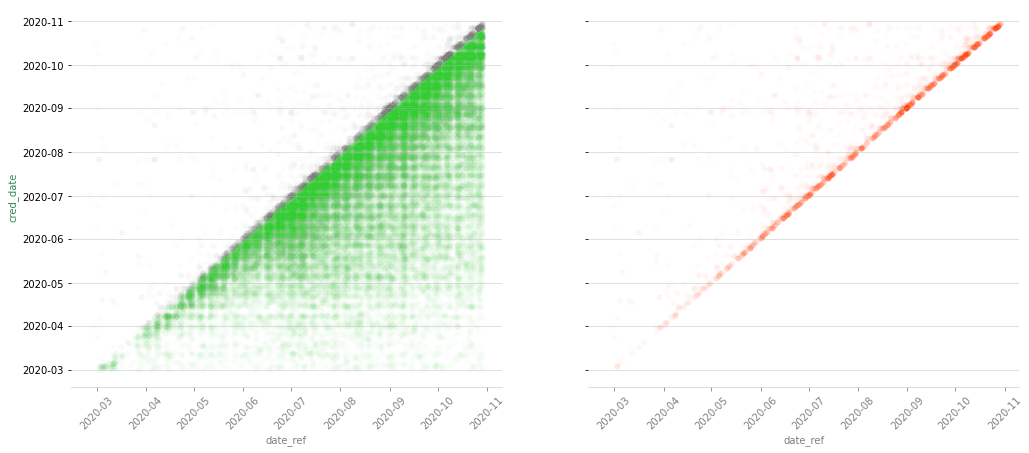

In [295]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (17, 7))

# First Plot
ax[0].grid(b = True, axis = 'y', alpha = .5, zorder = -1)
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[(mcases['cred_date'] >= '2020-03-01') & (mcases['cred_date'] < mcases['date_ref'])], 
                alpha = .02, color = 'limegreen', ax = ax[0])
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[mcases['cred_date'] > mcases['date_ref']], 
                alpha = .02, color = 'gray', ax = ax[0])

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='x', colors='gray', rotation = 45)
ax[0].yaxis.label.set_color("seagreen")

# Second plot
ax[1].grid(b = True, axis = 'y', alpha = .5, zorder = -1)
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[(mcases['cred_date'] >= '2020-03-01') & (mcases['cred_date'] < mcases['date_ref'])], 
                alpha = .0002, color = 'gray', hue = 'max_machine', ax = ax[1])
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[mcases['cred_date'] > mcases['date_ref']], 
                alpha = .02, color = 'orangered', ax = ax[1])

ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='x', colors='gray', rotation = 45)
ax[1].yaxis.label.set_color("seagreen")

sns.despine(top = True, left = True)

In [34]:
mcases.head(3)

,account_id,date_ref,waiting_time,missed,pesq_satisfacao,assunto,waiting_timedelta,year_cases,month_cases,day_cases,weekday_cases,weekday_str_cases,node_1,node_2,node_3,calls,cred_date,ship_city,ship_state,max_machine,year_creds,month_creds,day_creds,weekday_creds,weekday_str_creds,interval_cred_call
0,0011L00002ZbpnlQAB,2020-02-23,19,False,Enviado,"['Produto', 'mPOS', 'Dúvidas mpos']",0 days 00:00:19,2020,2,23,6,Dom,Produto,mPOS,Dúvidas mpos,1,2019-10-28,Atibaia,SP,NaN,2019,10,28,0,Seg,118
1,0011L00002dbBg5QAE,2020-02-25,15,False,Enviado,"['Aplicativo', 'Problema', '']",0 days 00:00:15,2020,2,25,1,Ter,Aplicativo,Problema,NaN,1,2020-02-12,Alexânia,GO,NaN,2020,2,12,2,Qua,13
2,0011L00002WdgbcQAB,2020-02-26,15,False,Enviado,"['Aplicativo', 'Dúvidas funcionalidades App', ...",0 days 00:00:15,2020,2,26,2,Qua,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,1,2019-07-28,Indaiatuba,SP,NaN,2019,7,28,6,Dom,213


In [38]:
# plt.figure(figsize = (15, 15))
# sns.jointplot('date_ref', 'cred_date', hue = 'month', kind = 'hex', data = mcases, alpha = 0.01);

In [39]:
mcases[mcases['node_1'] == 'Produto']['node_3'].value_counts()

Dúvidas                                 5887
Ativação                                2165
Dúvida S920                             1955
Falha de Conexão - não revertido        1853
Dúvida D195                             1697
Pareamento                              1417
Falha de Conexão - revertido             936
Dúvidas pinpad                           838
Problema                                 676
Atendimento acesso                       565
Problema Revertido                       264
Dúvidas mpos                             201
Falha no pareamento                      164
Atualização                              122
Falha de conexão - wifi - revertido      120
Alteração de dados na Acesso              91
Falha de conexão - GPRS - revertido       87
Transferência de Saldo entre cartões      53
Transferência de Saldo para conta         48
Falha na atualização                      21
Problema POS - revertido                  16
Falha na ativação                         11
Name: node

In [40]:
cases_per_state = mcases.groupby('ship_state')[['calls']].sum()
creds_per_state = creds.groupby('ship_state')[['account_id']].nunique()

agg_per_state = cases_per_state.merge(creds_per_state, right_index = True, left_index = True)
(agg_per_state['calls'] / agg_per_state['account_id']).sort_values(ascending = False)

ship_state
TO    2.761062
AC    2.678571
RN    2.610413
SE    2.591362
CE    2.584835
RJ    2.584454
BA    2.554893
GO    2.549713
MT    2.532338
PE    2.521799
PB    2.520548
ES    2.506472
AM    2.466667
MG    2.452963
PR    2.444838
MA    2.442460
DF    2.435312
SC    2.434295
PA    2.424855
AL    2.401662
AP    2.397436
RS    2.372508
SP    2.357311
MS    2.302920
PI    2.279310
RR    2.191489
RO    2.134328
dtype: float64

___
---

## Rascunhos

In [ ]:
# # Criando coluna cred_year_month para a tabela Creds
# creds['cred_year_month'] = creds['year'].astype(str) + '-' + creds['month'].astype(str)

In [ ]:
# mcases['cred_year_month'] = mcases['year_creds'].astype(str) + '-' + mcases['month_creds'].astype(str)

In [ ]:
# creds.groupby(pd.Grouper(key = 'cred_date', freq = 'W')).count()

In [ ]:
# _mcases_agg = mcases.copy()
# idx_to_drop = _mcases_agg[_mcases_agg['cred_date'] < '2020-02-23'].index
# mcases_ready = _mcases_agg.drop(idx_to_drop)

In [ ]:
# mcases[['account_id', 'date_ref', 'cred_date']]

In [ ]:
# # Aggregation functions to be passed to groupby
# aggregation = {
#     'n_creds': ('account_id', pd.Series.nunique),
#     'n_calls': ('date_ref', 'count')
# }

# # Groupby splitting dates in weeks and with specified aggregations
# mcases_agg = mcases_ready.groupby(pd.Grouper(key = 'cred_date', freq = 'W')).agg(**aggregation)
# mcases_idx_list = mcases_agg.index.tolist()

In [ ]:
# mcases_idx_list

In [ ]:
# n_calls_list = []
# for i, _ in enumerate(mcases_idx_list):
#     if i == 0:
#         df = mcases[mcases['cred_date'] <= mcases_idx_list[i]]
#         n_calls_from_cred_this_week = df[(df['date_ref'] >= mcases_idx_list[i]) & (df['date_ref'] < (mcases_idx_list[i + 1]))]['account_id'].nunique()
#         n_calls_list.append(n_calls_from_cred_this_week)
        
#     elif i != len(mcases_idx_list) - 1:
#         df = mcases[mcases['cred_date'] <= mcases_idx_list[i]]
#         n_calls_from_cred_this_week = df[(df['date_ref'] >= mcases_idx_list[i]) & (df['date_ref'] < (mcases_idx_list[i + 1]))]['account_id'].nunique()
#         n_calls_list.append(n_calls_from_cred_this_week)
        
#     else:    
#         df = mcases[mcases['cred_date'] <= mcases_idx_list[i]]
#         n_calls_from_cred_this_week = df[(df['date_ref'] >= mcases_idx_list[i])]['account_id'].nunique()
#         n_calls_list.append(n_calls_from_cred_this_week)

In [ ]:
# mcases_agg['n_calls_from_cred_this_week'] = n_calls_list
# mcases_agg

In [ ]:
# df[(df['date_ref'] >= mcases_idx_list[0]) & (df['date_ref'] < (mcases_idx_list[0 + 1]))]

In [ ]:
# date = mcases_idx_list[0]
# df = mcases[mcases['cred_date'] <= date]
# n_calls_from_cred_this_week = df[(df['date_ref'] >= date) & (df['date_ref'] < (date + np.timedelta64(1, 'D')))]['account_id'].nunique()
# n_calls_list.append(n_calls_from_cred_this_week)
# n_calls_list

In [ ]:
# df = mcases[(mcases['cred_date'] <= '2020-03-01') & (mcases['cred_date'] >= '2020-02-23')]
# df

In [ ]:
# mcases['date_ref'].min()

In [ ]:
# mcases_agg['n_calls_from_cred_this_week'] = None
# mcases_agg['n_calls_from_cred_this_week']
# # test = pd.DataFrame(mcases_agg.iloc[1]).T
# # test['teste'] = 0

# # test

In [ ]:
# _cred_sup = pd.DataFrame(creds.groupby('cred_year_month').count()['account_id'])
# _cred_sup

In [ ]:
# _cases_sup = pd.DataFrame(mcases.groupby('cred_year_month').count()['account_id']).rename(columns = {'account_id': 'n_calls'})
# _cases_sup

In [ ]:
# cred_calls = _cred_sup.merge(_cases_sup, how = 'outer', left_index = True, right_index = True)
# cred_calls

In [ ]:
# call_breakdown = mcases[['account_id', 'date_ref']].groupby('account_id').agg({'date_ref': ['min', 'max'], 
#                                                                                'account_id': 'count'})

# call_breakdown = call_breakdown.rename(columns = {'date_ref': 'calls', 'account_id': 'n_total_calls'})
# call_breakdown['timespan_first_last_call_days'] = call_breakdown['calls', 'max'] - call_breakdown['calls', 'min'] + np.timedelta64(1, 'D')
# call_breakdown['timespan_first_last_call_months'] = call_breakdown['timespan_first_last_call_days'].dt.days
# call_breakdown['call_per_month'] = call_breakdown['n_total_calls', 'count'] / call_breakdown['timespan_first_last_call_months']

# call_breakdown

In [ ]:
# call_breakdown.info()

In [ ]:
# call_breakdown['timespan_first_last_call_months'].describe()

In [ ]:
# sns.boxplot(call_breakdown[call_breakdown['timespan_first_last_call_months'] < 100]['timespan_first_last_call_months'])

In [ ]:
# sns.distplot(call_breakdown['timespan_first_last_call_months']);

In [ ]:
# def get_month_spam(df):
#     date_1 = df['calls', 'max']
#     date_2 = df['calls', 'min']
#     difference = relativedelta.relativedelta(date_2, date_1)
#     months = difference.months
#     return months

In [ ]:
# # Número de clientes que ligaram apenas uma ves
# print(len(call_breakdown[call_breakdown['n_total_calls', 'count'] == 1]))

# # Número de clientes que ligaram mais de uma vez
# print(len(call_breakdown[call_breakdown['n_total_calls', 'count'] > 1]))

In [ ]:
# call_breakdown['n_total_calls', 'count'].mean()
# call_breakdown['n_total_calls', 'count'].median()
# call_breakdown['n_total_calls', 'count'].std()

# call_breakdown['n_total_calls', 'count'].value_counts() 
# #  * call_breakdown['n_total_calls', 'count'].value_counts().index )

In [ ]:
# # Número de ligações - clientes que ligaram apenas uma vez
# print(call_breakdown['n_total_calls', 'count'].value_counts()[:1].sum())

# # Número de ligações - clientes que ligam mais de uma vez
# print(call_breakdown[call_breakdown['n_total_calls', 'count'] > 1]['n_total_calls', 'count'].sum())

In [ ]:
# mcases['interval_7'] = (mcases['interval_cred_call'] <= 7).astype(int)
# mcases['interval_14'] = ((mcases['interval_cred_call'] > 7) & (mcases['interval_cred_call'] <= 14)).astype(int)
# mcases['interval_21'] = ((mcases['interval_cred_call'] > 14) & (mcases['interval_cred_call'] <= 21)).astype(int)
# mcases['interval_28'] = ((mcases['interval_cred_call'] > 21) & (mcases['interval_cred_call'] <= 28)).astype(int)
# mcases['interval_35'] = ((mcases['interval_cred_call'] > 28) & (mcases['interval_cred_call'] <= 35)).astype(int)

# mcases_intervals = mcases.groupby('account_id')[['interval_7', 'interval_14', 'interval_21', 'interval_28', 'interval_morethan_28']].sum()

In [ ]:
# mcases_intervals['interval_7'].sum(), \
# mcases_intervals['interval_14'].sum(), \
# mcases_intervals['interval_21'].sum(), \
# mcases_intervals['interval_28'].sum(), \
# mcases_intervals['interval_morethan_28'].sum()

In [ ]:


# sum_intervals = sum((mcases_intervals['interval_7'].sum(), \
# mcases_intervals['interval_14'].sum(), \
# mcases_intervals['interval_21'].sum(), \
# mcases_intervals['interval_28'].sum(), \
# mcases_intervals['interval_morethan_28'].sum())[0:4])

# sum_intervals / len(mcases) 

In [ ]:
# sns.distplot(mcases['cred_date'])
# sns.distplot(mcases['date_ref'])

In [ ]:
# plt.figure(figsize = (7, 7))
# ax = plt.gca()

# plt.hexbin(pl.date2num(mcases['date_ref']), pl.date2num(mcases['cred_date']), 
#            gridsize = 100,
#            alpha = .7, 
#            cmap = 'ocean_r',
#            bins = 'log')
# ax.legend()
# ax.yaxis_date()
# ax.xaxis_date()
# plt.xticks(rotation = 45);

In [ ]:
# mcases_first_call = mcases.groupby('account_id').agg({'date_ref': 'min', 'cred_date': 'min'})
# mcases_first_call['days_until_first_call'] = (mcases_first_call['date_ref'] - mcases_first_call['cred_date']).dt.days
# (mcases_first_call['days_until_first_call']).median()

# sns.distplot(mcases_first_call[mcases_first_call['days_until_first_call'] >= 0]['date_ref'])

In [ ]:
# cred_cases_shifted_3days = cred_cases[['n_creds']].merge(cred_cases.iloc[:, 1:].shift(10), 
#                                                          how = 'inner', 
#                                                          left_index = True,
#                                                          right_index = True)

# cred_cases_shifted_3days = cred_cases_shifted_3days.dropna(axis = 0, how = 'any')
# cred_cases_shifted_3days = cred_cases_shifted_3days.iloc[:-10, :] # Dropando últimas três linhas para fair analysis

In [ ]:
# cred_cases_shifted_3days_before = cred_cases_shifted_3days[cred_cases_shifted_3days.index < shift_date]
# cred_cases_shifted_3days_after = cred_cases_shifted_3days[cred_cases_shifted_3days.index >= shift_date]

In [ ]:
# cred_cases_shifted_3days_before.shape, cred_cases_shifted_3days_after.shape

In [ ]:
# cred_cases_shifted_3days_before

In [ ]:
# plt.figure(figsize = (10, 6))
# sns.distplot(cred_cases_shifted_3days_before['calls_per_total_creds'], color = 'red') # ANTES DA IMPLEMENTAÇÃO
# sns.distplot(cred_cases_shifted_3days_after['calls_per_total_creds'], color = 'green'); # DEPOIS DA IMPLEMENTAÇÃO

In [84]:
import math
n = 3
a_n = ((-25 * n) + 12) / np.sqrt(16*n^2 + n) 

In [85]:
a_n

-8.653715528767409